In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
sns.set_style('dark')

# Introduction
In this notebook, airline passenger satisfaction is predicted from the results of a passenger satisfaction survey.

# Loading Data

In [2]:
df_train  = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')

In [3]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
# Removes the unnecessary feature that just duplicates the index and passenger id feature
df_train.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)


# Data CLeaning

## Checking for NaN Values

In [5]:
nan_columns = [col for col in df_train.columns if df_train[df_train[col].isna()].shape[0] > 0]
if len(nan_columns) > 0:
    print('NaN values in the following column(s) of the train set:')
    print(nan_columns)
else:
    print('No NaN values in any columns.')

    nan_columns = [col for col in df_test.columns if df_test[df_train[col].isna()].shape[0] > 0]
if len(nan_columns) > 0:
    print('NaN values in the following column(s) of the train set:')
    print(nan_columns)
else:
    print('No NaN values in any columns.')

NaN values in the following column(s) of the train set:
['Arrival Delay in Minutes']
NaN values in the following column(s) of the train set:
['Arrival Delay in Minutes']


## Handling NaNs in "Arrival Delay in Minutes"

In [6]:
num_nans = df_train[df_train['Arrival Delay in Minutes'].isna()].shape[0]
print(f'NaN values present in {num_nans} samples out of {df_train.shape[0]} in the train set')

NaN values present in 310 samples out of 103904 in the train set


In [7]:
num_nans = df_test[df_test['Arrival Delay in Minutes'].isna()].shape[0]
print(f'NaN values present in {num_nans} samples out of {df_test.shape[0]} in the test set')

NaN values present in 83 samples out of 25976 in the test set


There are relatively few samples with missing values, so the samples with missing values are dropped.

In [8]:
df_train = df_train[df_train['Arrival Delay in Minutes'].notna()]
df_test = df_test[df_test['Arrival Delay in Minutes'].notna()]

# Exploratory Data Analysis
The data contains the following features

* Nominal Categories
    * Gender
    * Customer type (loyal or disloyal customer)
    * Type of Travel (business or personal)
    * Class (Business, Eco, Eco Plus)
* Continuous Features
    * Age (treated as continuous but only takes integer values)
    * Flight distance (treated as continuous but only takes integer values)
    * Arrival Delay in Minutes
    * Departure Delay in Minutes
* Ordinal Categories - each represents a customer satisfaction rating with respect to the feature name
    * Inflight wifi service
    * Ease of Online Booking
    * Gate Location
    * Food and Drink
    * Online boarding
    * Seat Comfort
    * Inflight entertainment
    * On-board service
    * Leg room service
    * Baggage Handling
    * Check-in service
    * Inflight Service
    * Cleanliness
* Binary Category
    * Satisfaction - the target variable

In [9]:
df_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Target Variable Balance
I begin with satisfaction since it is the target variable. I encode the variable such that satisfied = 1 and neutral or dissatisfied = 0. Then I check the relative representation of each category.

In [10]:
dissatisfied = df_train['satisfaction'].value_counts()['neutral or dissatisfied']
satisfied = df_train['satisfaction'].value_counts()['satisfied']
print(f'Approximately {np.round(100*dissatisfied/(satisfied+dissatisfied), decimals=3)}% of passengers were satisfied.')

Approximately 56.661% of passengers were satisfied.


The satisfaction feature is not very imbalanced. As such, an oversampling technique like SMOTE is likely unnecessary.

In [11]:
df_train.loc[df_train['satisfaction'] == 'neutral or dissatisfied', 'satisfaction'] = 0
df_train.loc[df_train['satisfaction'] == 'satisfied', 'satisfaction'] = 1
df_train['satisfaction'] = df_train['satisfaction'].astype(np.int64)


df_test.loc[df_test['satisfaction'] == 'neutral or dissatisfied', 'satisfaction'] = 0
df_test.loc[df_test['satisfaction'] == 'satisfied', 'satisfaction'] = 1
df_test['satisfaction'] = df_test['satisfaction'].astype(np.int64)

In [12]:
continuous_features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
nominal_categories = ['Class', 'Type of Travel', 'Customer Type', 'Gender']
ordinal_categories = [col for col in df_train.columns if col not in continuous_features + nominal_categories]

## Nominal Categories

In [13]:
print(f'This category contains the following features:')
print(nominal_categories)

This category contains the following features:
['Class', 'Type of Travel', 'Customer Type', 'Gender']


### Overall Counts

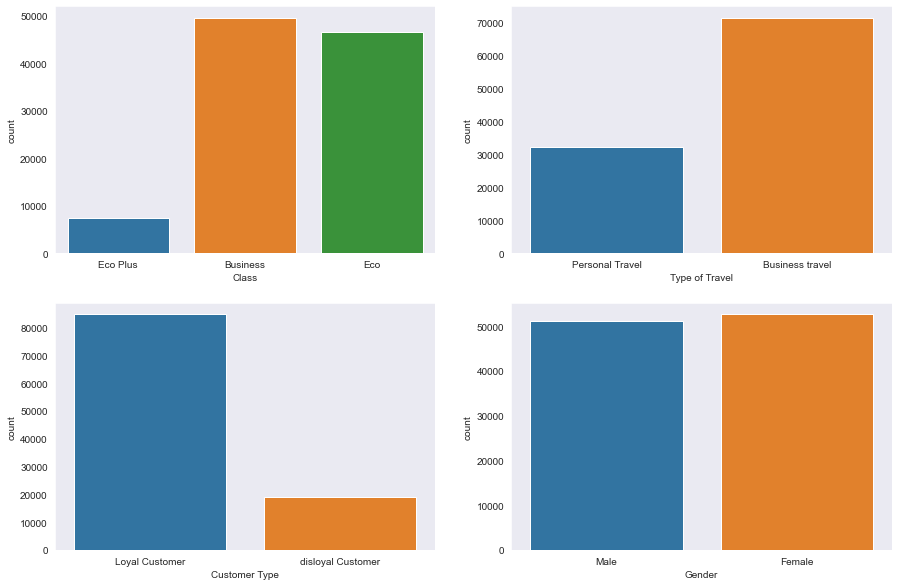

In [14]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
sns.countplot(data=df_train, x='Class', ax=axes[0][0])
sns.countplot(data=df_train, x='Type of Travel', ax=axes[0][1])
sns.countplot(data=df_train, x='Customer Type', ax=axes[1][0])
sns.countplot(data=df_train, x='Gender', ax=axes[1][1])
plt.show()

### Counts with Respect to Satisfaction

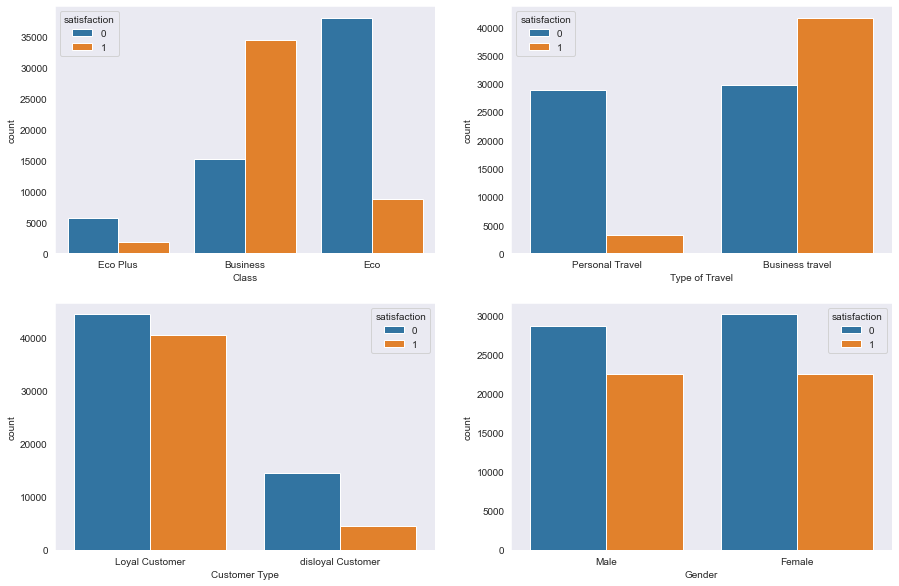

In [15]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
sns.countplot(data=df_train, x='Class', hue='satisfaction', ax=axes[0][0])
sns.countplot(data=df_train, x='Type of Travel', hue='satisfaction', ax=axes[0][1])
sns.countplot(data=df_train, x='Customer Type', hue='satisfaction', ax=axes[1][0])
sns.countplot(data=df_train, x='Gender', hue='satisfaction', ax=axes[1][1])
plt.show()

Here, some relationships between the nominal features and target features begin to appear. Specifically, travellers in economy tend to be dissatisfied, while business class passengers tend to be satisfied. Similarly, most people travelling for personal reasons are dissatisfied, while slightly more business travellers are satisfied than dissatisfied.

## Correlations of Numerical Variables

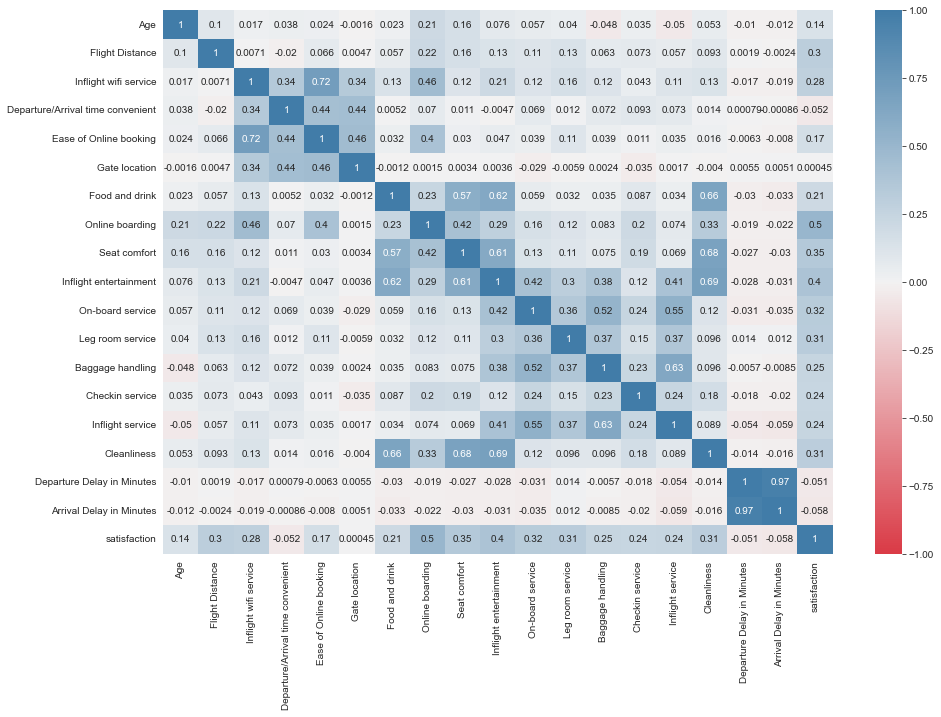

In [16]:
div_cmap = sns.diverging_palette(h_neg=10, h_pos=240, n=9, as_cmap=True)
corr = df_train.corr()
plt.figure(figsize=(15,10))
sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, cmap=div_cmap)
plt.show()

There are some correlations with satisfaction, mostly weak. The strongest is with the online boarding satisfaction feature, with a coefficient of 0.5.

There is also some colinearity between the features. The strongest is between arrival and departure delays, which makes sense. The departure arrival delay is dropped.

There are some unexpected  but moderately strong correlations, such as between satisfaction with online booking and satisfaction with inflight wifi.

In [17]:
df_test.drop(['Departure Delay in Minutes'], axis=1, inplace=True)
df_train.drop(['Departure Delay in Minutes'], axis=1, inplace=True)
continuous_features.remove('Departure Delay in Minutes')

### Overall Ordinal Variable Distribution

In [18]:
print(f'This category contains the following features:')
print(ordinal_categories)

This category contains the following features:
['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction']


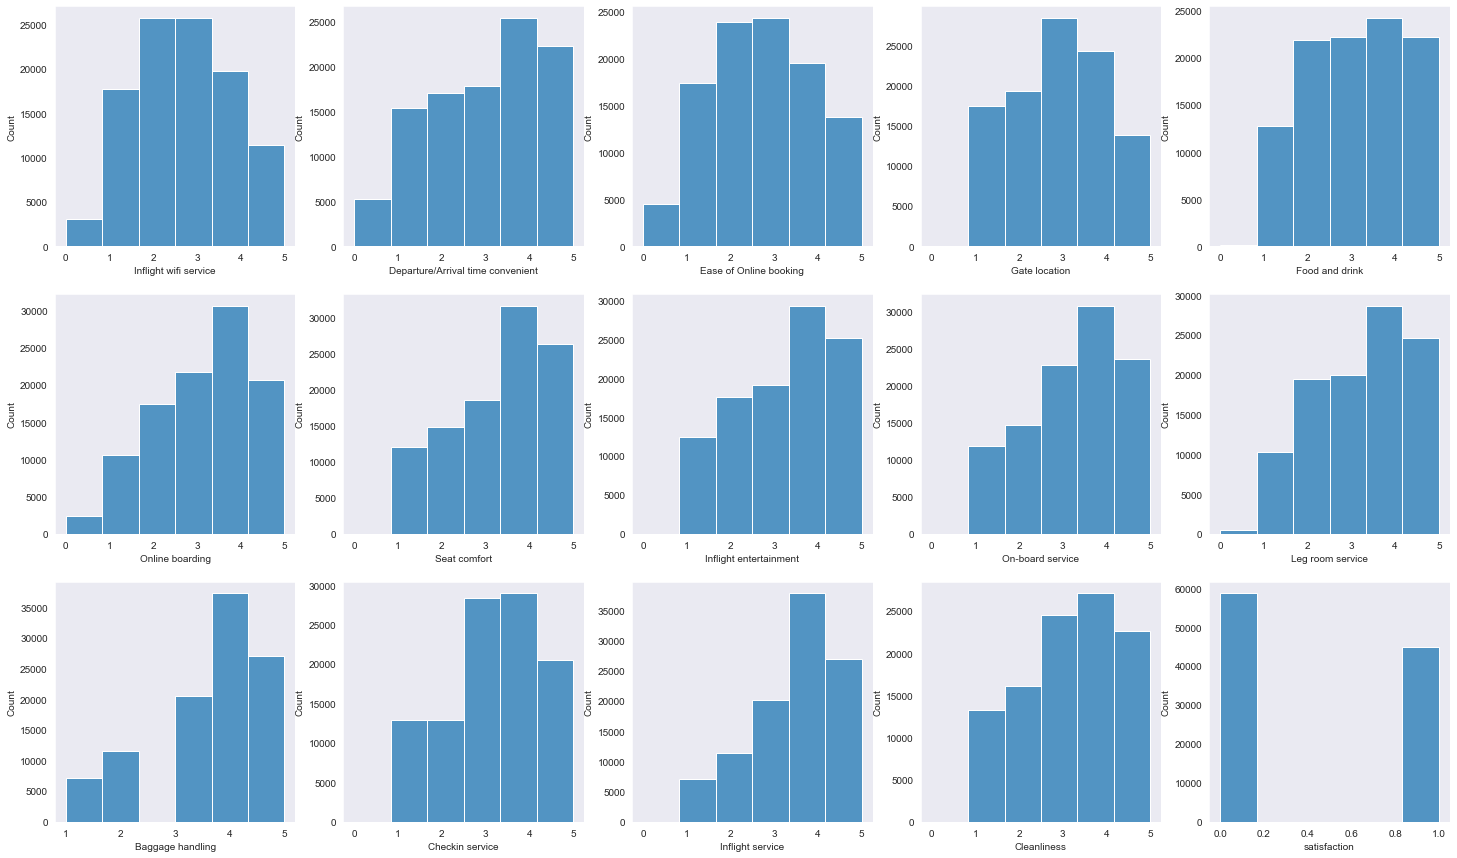

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(25,15))
axes = np.ravel(axes)

for i, feature in enumerate(ordinal_categories):
    sns.histplot(data=df_train, x=feature, ax=axes[i], bins=6)
plt.show()

A general trend here is that the distributions tend to be assymetrical, with more higher satisfaction ratings than low ones. This is good for the airline but potentially bad when using models that assume normally distributed features.

### Overall Ordinal Variable Distribution by Satisfaction

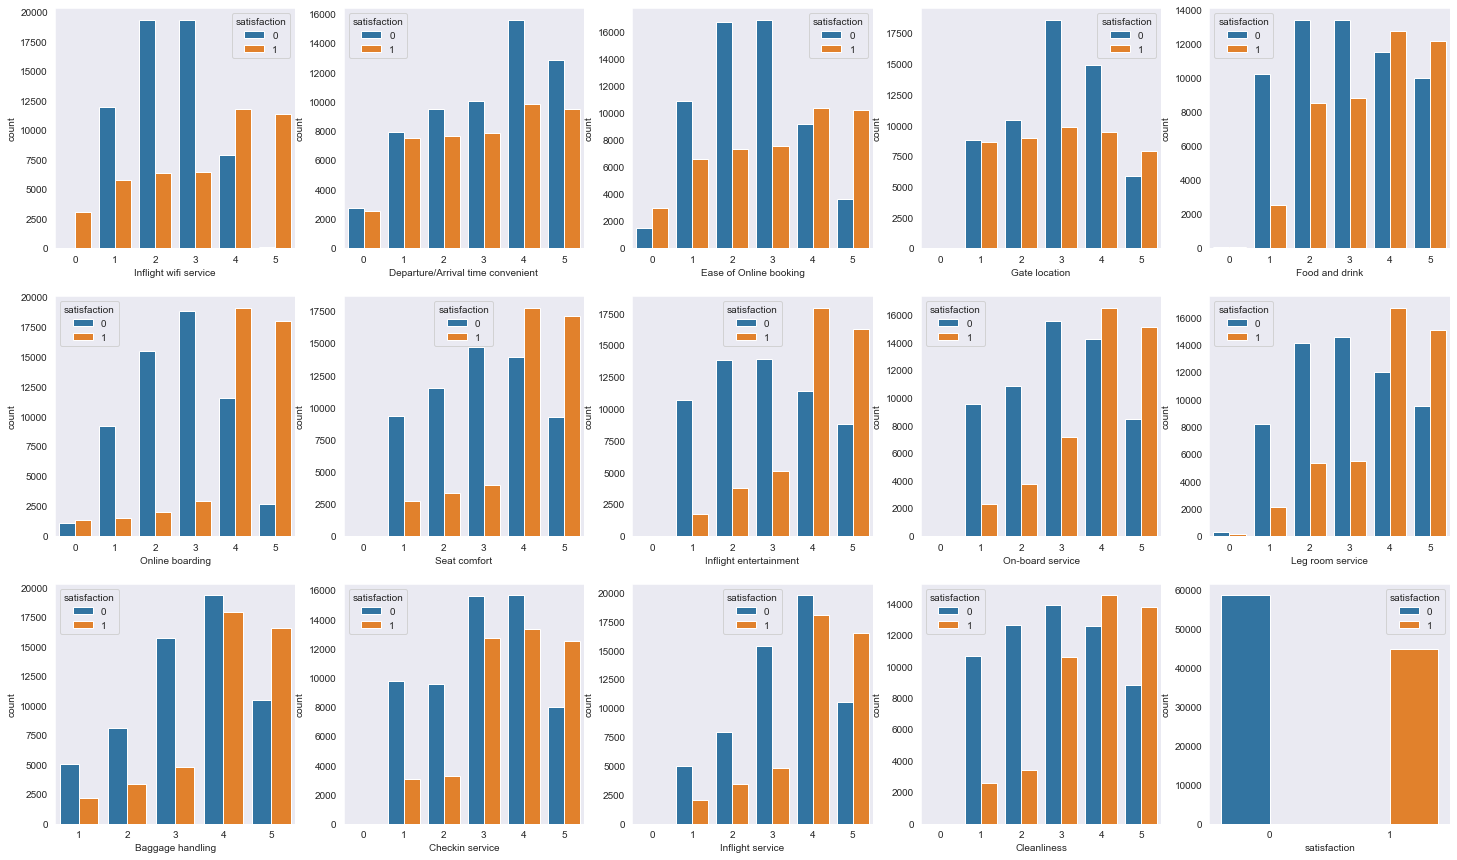

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(25,15))
axes = np.ravel(axes)

for i, feature in enumerate(ordinal_categories):
    sns.countplot(data=df_train, x=feature, hue='satisfaction', ax=axes[i])

The general trend out of these plots is an unsurprising one: dissatisfied passengers tend to be overrepresented among passengers who provided a low rating for a feature. On the other hand, among passengers that provided a rating of 5 for a feature, there are more satisfied passengers.

## Continuous Features

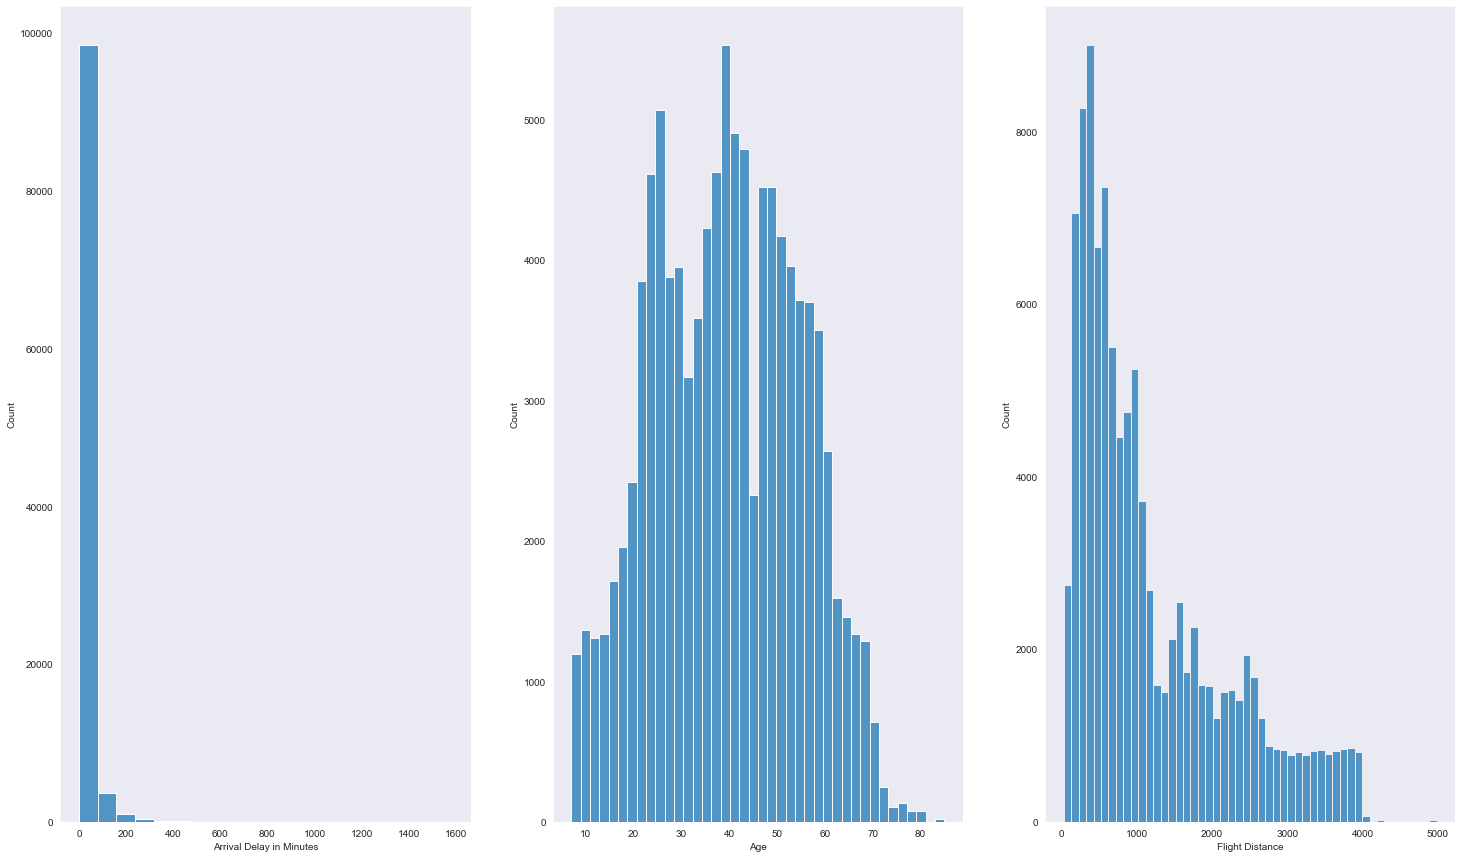

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(25,15))

sns.histplot(data=df_train, x='Arrival Delay in Minutes', ax=axes[0], bins=20)
sns.histplot(data=df_train, x='Age', ax=axes[1], bins=40)
sns.histplot(data=df_train, x='Flight Distance', ax=axes[2], bins=50)

plt.show()

None of the distributions look normal. 


The arrival delay is heavily skewed. This is further examined below.

The age plot has a number of interesting features. It peaks in the mid 20s, dips in the mid 30s then increases again towards the 40s. There are also bins that seem over represented and a bin at 40 that seems unusually low. Neither the peaks themselves nor the over-representation have obvious explanations and would probably require a subject matter expert to explain. The overall trend of increasing toward middle age and then decreasing again is intuitively reasonable but the exact shape of the distribution evades an obvious explanation.

#### Arrival Delays

In [22]:
longest_delay = df_train['Arrival Delay in Minutes'].max()
zero_counts = df_train[df_train['Arrival Delay in Minutes'] == 0].shape[0]
total_count = df_train.shape[0]
print(f'The longest delay was {longest_delay} minutes.')
print(f'There are {zero_counts} samples with no arrival delay, accounting for {np.round(100*zero_counts/(zero_counts+total_count))}% of the flights.')

The longest delay was 1584.0 minutes.
There are 58159 samples with no arrival delay, accounting for 36.0% of the flights.


##### Arrived Late by Over 300 Minutes

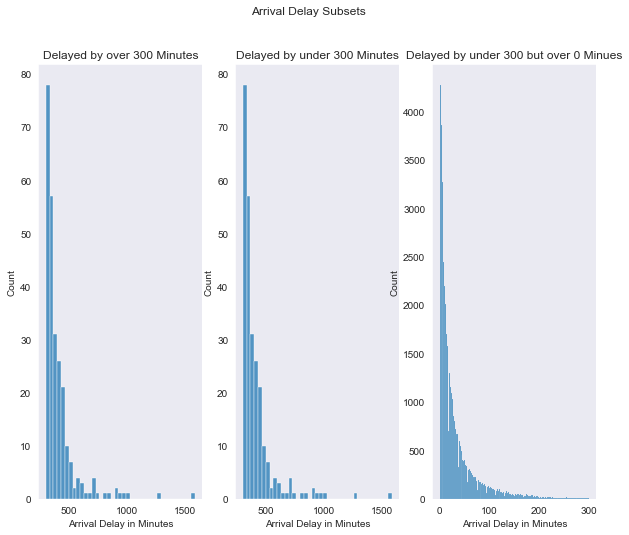

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(10,8))
fig.suptitle('Arrival Delay Subsets')
axes[0].set_title('Delayed by over 300 Minutes')
late_departure = df_train[df_train['Arrival Delay in Minutes'] > 300]
sns.histplot(data=late_departure, x='Arrival Delay in Minutes', ax=axes[0])


axes[1].set_title('Delayed by under 300 Minutes')
late_departure = df_train[df_train['Arrival Delay in Minutes'] > 300]
sns.histplot(data=late_departure, x='Arrival Delay in Minutes', ax=axes[1])

axes[2].set_title('Delayed by under 300 but over 0 Minues')
late_arrival = df_train[(df_train['Arrival Delay in Minutes'] < 300) & (df_train['Arrival Delay in Minutes'] > 0)]
sns.histplot(data=late_arrival, x='Arrival Delay in Minutes', ax=axes[2])
plt.show()

##### Arrival Delay and Satisfaction

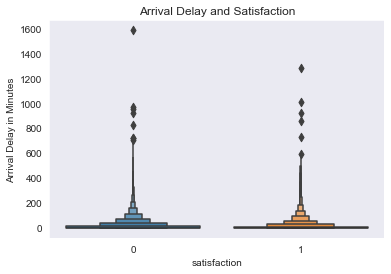

In [24]:
sns.boxenplot(data=df_train, x='satisfaction', y='Arrival Delay in Minutes')
plt.title('Arrival Delay and Satisfaction')
plt.show()

#### Age and Satisfaction

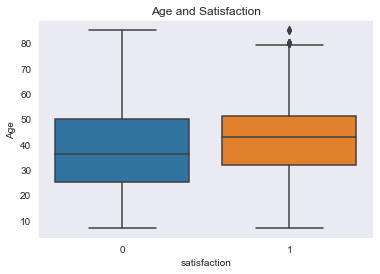

In [25]:
sns.boxplot(data=df_train, x='satisfaction', y='Age')
plt.title('Age and Satisfaction')
plt.show()

Satisfied passengers have a higher median age.

#### Flight Distance and Satisfaction

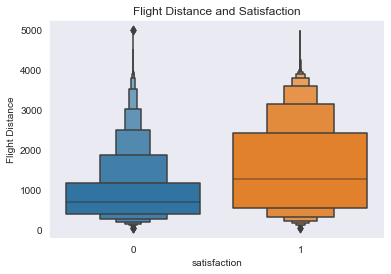

In [26]:
sns.boxenplot(data=df_train, x='satisfaction', y='Flight Distance')
plt.title('Flight Distance and Satisfaction')
plt.show()

There is a noticeable relationship between satisfaction and flight distance. Specifically, the median distance is higher for satisfied customers, and generally customers on longer flights seems more likely to be satisfied.

From the above, it is clear that the shape of the distribution of all arrival times is driven by the large number of samples with no delay. The other key factor is a relatively small number of delays that were over 300 minutes.

### Continuous Features with Respect to Class

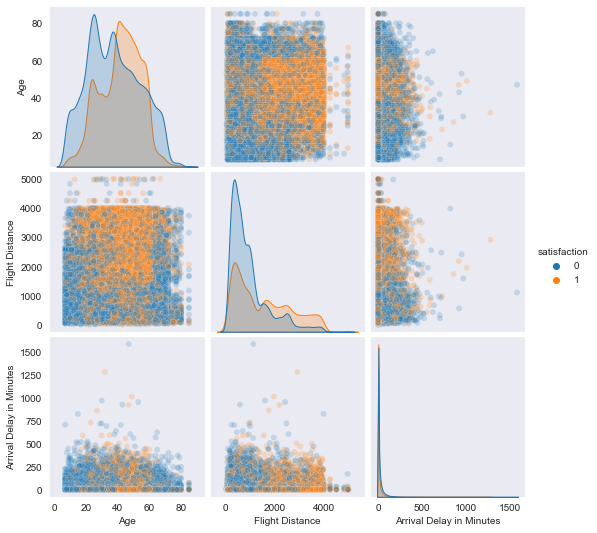

In [27]:
sns.pairplot(data=df_train[continuous_features + ['satisfaction']], hue='satisfaction', plot_kws={'alpha':0.2})
plt.show()

Dissatisfied customers tend to be younger and have flown shorter distances. The latter conclusion should be tempered by the fact that shorter flights are more common than longer flights. There is no obvious separability among classes, perhaps in the Age v. Flight distance plot. Looking at those feature alone, it appears that any separability may be nonlinear.

# Encoding Nominal Variables

## Training Data

In [28]:
dummy_features = []
for var in nominal_categories:
    dummy_features = pd.get_dummies(df_train[var])
    df_train.drop(labels=var, inplace=True, axis=1)
    df_train = pd.concat([df_train, dummy_features], axis=1)


## Testing Data

In [29]:
dummy_features = []
for var in nominal_categories:
    dummy_features = pd.get_dummies(df_test[var])
    df_test.drop(labels=var, inplace=True, axis=1)
    df_test = pd.concat([df_test, dummy_features], axis=1)


# Model Traininng
First spot checking is used to determine what model might perform well on the data. Then hyperparameters are selected through cross validation. Finally, a random forest is trained on the data.

In [30]:
y_train = df_train.pop('satisfaction')
x_train = df_train

ss =StandardScaler()
x_train_scaled = ss.fit_transform(x_train)

y_test = df_test.pop('satisfaction')
x_test = df_test

In [31]:
for col in df_train.columns:
    if col not in df_test.columns:
        print(col)

## Spot Checking
To get an idea of what models to use, spot checking is performed.

In [32]:
ensembles = [('K-Nearest Neighbors', KNeighborsClassifier()), ('Linear SVC', LinearSVC(dual=False, random_state=123)), ('SVM with RBF Kernel', SVC(random_state=123)), ('Random Forest', RandomForestClassifier(random_state=123)), ('Bagging',BaggingClassifier(random_state=123)), ('AdaBoost', AdaBoostClassifier(random_state=123))]
for tup in ensembles:
    clf = tup[1]
    # Split and scale the data
    

    scores = cross_val_score(clf, x_train_scaled, y_train)
    print(f'********************Results for {tup[0]}********************')
    print('Mean score: ', np.mean(scores))
    print('Score standard deviation', np.std(scores))
    print()

********************Results for K-Nearest Neighbors********************
Mean score:  0.9264340034920215
Score standard deviation 0.0023767536935797333

********************Results for Linear SVC********************
Mean score:  0.8745487666082674
Score standard deviation 0.0025016088530079817

********************Results for SVM with RBF Kernel********************
Mean score:  0.9538293898589366
Score standard deviation 0.0014825829554729341

********************Results for Random Forest********************
Mean score:  0.9629804968567004
Score standard deviation 0.0012144468988797396

********************Results for Bagging********************
Mean score:  0.9587234941128706
Score standard deviation 0.0011429894961267838

********************Results for AdaBoost********************
Mean score:  0.9278819251276025
Score standard deviation 0.0020172575180281557



Spot checking suggests that, while many non-linear models will perform well, a random forest may perform the best. A random forest model is used going forwards.

## Feature Importance: Mutual Information
For feature selection, the features with the k best mutual information scores are selected, where k is a hyperparameter to be cross validated. Mutual information measures dependence between variables, similarly to a correlation coefficient. Specifically, for two random variables X and Y, the mutual information quantifies the difference between the variables' joint distribution and the product of their marginal distributions. If the joint distribution and the product of the marginal distribution are the same, i.e. the variables are independent, the mutual information is zero. Higher values of the mutual information indicate greater dependence. The mutual information for each feature is below.

In [33]:
mutual_info = mutual_info_classif(x_train_scaled, y_train, random_state=123)
mutual_info = [np.round(MI, decimals=4) for MI in mutual_info]
mutual_info_zip = zip(df_train.columns, mutual_info)
mutual_info = sorted(list(mutual_info_zip), key = lambda x: x[1], reverse=True)
print('Mutual information between features and the target variable:')
mutual_info

Mutual information between features and the target variable:


[('Online boarding', 0.2126),
 ('Inflight wifi service', 0.1655),
 ('Business', 0.1396),
 ('Business travel', 0.1211),
 ('Personal Travel', 0.1197),
 ('Eco', 0.1129),
 ('Inflight entertainment', 0.0954),
 ('Seat comfort', 0.0812),
 ('Leg room service', 0.0657),
 ('On-board service', 0.0585),
 ('Flight Distance', 0.0584),
 ('Cleanliness', 0.0539),
 ('Ease of Online booking', 0.0514),
 ('Age', 0.0448),
 ('Baggage handling', 0.0433),
 ('Inflight service', 0.0407),
 ('Checkin service', 0.0333),
 ('Food and drink', 0.0243),
 ('Loyal Customer', 0.0215),
 ('disloyal Customer', 0.0204),
 ('Gate location', 0.0128),
 ('Eco Plus', 0.0107),
 ('Arrival Delay in Minutes', 0.0087),
 ('Male', 0.0075),
 ('Departure/Arrival time convenient', 0.0059),
 ('Female', 0.0042)]

## Cross Validation
Hyperparameters are selected with cross validation. The hyperparameters to be tuned are the following
* The number of features to select
* The maximum depth of any decision tree in the random forest
* The maximum features to consider when splitting at each node of a tree in the random forest
* The number of decision trees in the random forest

In [34]:
import warnings
def do_cv(xtrain, ytrain, xtest, ytest):
    fs = SelectKBest(score_func=mutual_info_classif)
    scaler = StandardScaler()
    rf = RandomForestClassifier(random_state=1234)
    pipeline = Pipeline(steps= [('fs', fs), ('scaler', scaler), ('clf', rf)])

    feature_num_range = np.linspace(4, x_train_scaled.shape[1]+3, num=x_train_scaled.shape[1]//4, dtype=int)
    max_depth_range = np.linspace(4,6, num=3, dtype=int)
    max_feature_range = np.linspace(1, x_train.shape[1] - 1, num=11, dtype=int)
    n_estimator_range = np.linspace(500, 1200, num=8, dtype=int)

    params = {'fs__k':feature_num_range, 'clf__max_depth': max_depth_range, 'clf__max_features':max_feature_range, 'clf__n_estimators':n_estimator_range}

    #gs = GridSearchCV(pipeline, params, verbose=10, n_jobs=-1)
    gs = RandomizedSearchCV(pipeline, params, n_iter=300, verbose=1, n_jobs=-1, random_state=123)


    # Just catches warnings re NaNs
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(xtrain, ytrain)

    rf = gs.best_estimator_

    rf.fit(xtrain, ytrain)

    train_score = rf.score(xtrain, ytrain)
    test_score = rf.score(xtest, ytest)

    return {'test_score':test_score, 'train score': train_score, 'estimator':rf}
cv_results = do_cv(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [43]:
cv_results['estimator']

Pipeline(steps=[('fs',
                 SelectKBest(k=24,
                             score_func=<function mutual_info_classif at 0x0000017B8C2A2A60>)),
                ('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_features=13,
                                        n_estimators=600, random_state=1234))])

# Evaluation
As shown above, the model selected 24 features to use for training. The classifier consists of 1200 decision trees. Each decision tree was allowed a maximum depth of 6. When considering about which feature to split, the model looked at a maximum of 13 features.

In [44]:
# Split and scale the data
ss =StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

In [45]:
pipe = cv_results['estimator']
feature_selector = pipe.steps[0][1]
clf = pipe.steps[2][1]
y_hat = pipe.predict(x_test)
# Features Selected by SelectKBest
feature_names = df_train.iloc[:, feature_selector.get_support(indices=True)].columns


## Performance
The performance is evaluated by considering the accuracy, f1-score, precision and recall of the model; however, given that this is a fairly balanced binary classification model, it is safe to use accuracy as a metric to summarize model performance.

In [46]:
cv_results
test_percent =np.round(cv_results['test_score']*100, decimals=2)
train_percent =np.round(cv_results['train score']*100, decimals=2)

print(f'The model correctly categorized {test_percent}% of samples in the test set.')
print(f'The model correctly categorized {train_percent}% of samples in the training set.')

The model correctly categorized 93.51% of samples in the test set.
The model correctly categorized 93.55% of samples in the training set.


With the small discrepancy in performance on the training and test sets, it is safe to conclude that the model haas not overfit.

In [47]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     14528
           1       0.93      0.92      0.93     11365

    accuracy                           0.94     25893
   macro avg       0.93      0.93      0.93     25893
weighted avg       0.94      0.94      0.94     25893



Noting again that the data is not particularly imbalanced, the model has an accuracy of 94%. Additionally, it has similar performance on the class specific metrics, and the F1-scores, reaffirming the conclusion that imblance does not drive the model's performance.

In more detail, the precision is the portion of positive identifications of a class that were correct. This is fairly high for both classes. The recall is the portion of actual instances of the class that were identified. This is again very high. The F1 score is a harmonic mean of precision and recall.

It is perhaps noteworthy that performance is slightly better on the overrepresented class.

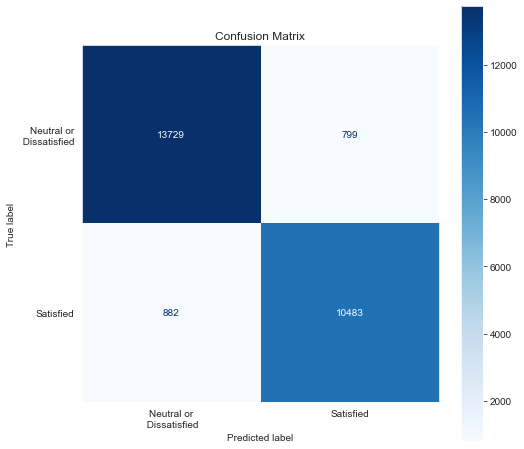

In [48]:
cm = confusion_matrix(y_test, y_hat)
fig, ax = plt.subplots(figsize=(8,8))
cmd = ConfusionMatrixDisplay(cm, display_labels=['Neutral or\n Dissatisfied', 'Satisfied'])
cmd.plot(cmap='Blues', values_format='d', ax=ax)
cmd.ax_.set(title='Confusion Matrix')
plt.show()


This model presents the same information in the table above in a more visual way.  The squares in the diagonal are correct identifications. The off-diagonal squares are incorrect identifications.

## Feature Selection and Importance

### Features Selected
The model only discarded two features. The features that were selected and disregarded are shown below. Interestingly, the model discarded features with low mutual information; however, the feature with the lowest mutual information - "female" - was kept in the model. As shown in a plot above, there really is not that much difference between the relative number of satisfied and dissatisfied passengersx when split by gender. As such, it could be worth considering dropping the male feaature and renaming the female feature to "gender" to avoid any appearance of gender bias.

In [49]:
print('Selected the following features:')
print([feature for feature in feature_names])
print()
print('Eliminated the following features:')
print([feature for feature in df_train.columns if feature not in feature_names])

Selected the following features:
['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Arrival Delay in Minutes', 'Business', 'Eco', 'Eco Plus', 'Business travel', 'Personal Travel', 'Loyal Customer', 'disloyal Customer']

Eliminated the following features:
['Female', 'Male']


### Feature Importance
Below is a plot of the relative importance of each selected feature.

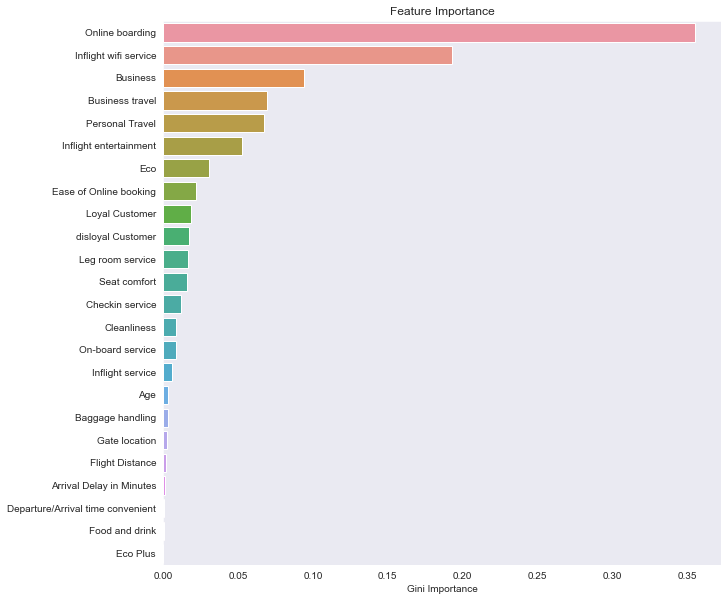

In [50]:
feature_scores = clf.feature_importances_
feature_pairs = zip(feature_names, feature_scores)
feature_pairs = sorted(list(feature_pairs), key=lambda x: x[1], reverse=True)
feature_names = [pair[0] for pair in feature_pairs]
feature_scores = [pair[1] for pair in feature_pairs]
plt.figure(figsize=(10,10))
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
sns.barplot(x=feature_scores, y=feature_names)
plt.show()

Above, the importance to the model of each feature is shown. The feature importance falls off quite quickly.

# Conclusion
An effective random forest model waas trained from the data, achieving 94% accuracy on the test set and similar precision, recall and F1-scores on the classes within the test set.